In [1]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from scipy.stats import binned_statistic_dd
import filter_masks
import pickle
from scipy import stats

In [2]:
#load data
experiment_run_name = "sxri0414run60"
my_file = experiment_run_name+".h5"
my_hdf5_object = h5py.File("../small_h5_data/"+my_file,"r")

In [3]:
#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    my_dict[i] = array(my_hdf5_object[i])
pixel_to_femtosecond_list = []
width_list = []

In [4]:
try:
    last_results = my_results.copy()
except:
    pass
#configuration parameters
time_tool_sign = 1
#pixel_to_femtosecond = 0.0033444
pixel_to_femtosecond = 0.002
delay_stage_offset = min(my_dict['delayStage'])

In [5]:
#subplot(121)
#hist(my_dict['timeToolOpal/time_pixel'],bins=arange(0,600,6))
#subplot(122)
#plot(my_dict['ebeam/photon_energy'],my_dict['GMD'],'.')
#xlim(900,930)
#show()

In [6]:
#make mask
my_mask =  filter_masks.__dict__[experiment_run_name](my_dict)
my_mask *=  (my_dict['timeToolOpal/time_pixel']>300)
my_mask *=  (my_dict['timeToolOpal/time_pixel']<1600)
#my_mask *=  (my_dict['ebeam/photon_energy']<925)
#my_mask *=  (my_dict['ebeam/photon_energy']>910)
#my_mask *=  (my_dict['timeToolOpal/uncertainty_cov']*pixel_to_femtosecond<0.0002)

/reg/data/ana13/sxr/sxri0414/res/automated_analysis/jupyter_notebooks/filter_masks.py:14: RuntimeWarning: invalid value encountered in greater
  myMask = myMask * (array(myDict['gas_detector/f_11_ENRC'])>1)


In [7]:
#TSS_OPAL/pixelTime = is the original psana type analyzed time tool data
#timeToolOpal/time_pixel = this is the custom analyzed time tool data using eigen backgrounds
#my_dict['corrected_time'] = (2/.3*(my_dict['delayStage']-delay_stage_offset)+time_tool_sign*(my_dict['TSS_OPAL/pixelTime']-mean(my_dict['TSS_OPAL/pixelTime'][my_mask]))*pixel_to_femtosecond )
my_dict['corrected_time'] = (2/.3*(my_dict['delayStage']-delay_stage_offset)+time_tool_sign*(my_dict['timeToolOpal/time_pixel']-mean(my_dict['timeToolOpal/time_pixel'][my_mask]))*pixel_to_femtosecond )

In [8]:
#subplot(121)
#plot(my_dict['GMD'][my_mask],my_dict['acqiris2/amplitude'][my_mask],'.')
#ylim(-0.1,1)
#subplot(122)
#hist(my_dict['TSS_OPAL/pixelTime'][my_mask]*pixel_to_femtosecond,bins=arange(0.6,2.0,0.001))
#show()

In [9]:
#subplot(121)
#hist(abs(my_dict['timeToolOpal/uncertainty_cov'])**0.5,bins=arange(-0.1,1,0.01))
#subplot(122)
#hist(abs(my_dict['timeToolOpal/time_pixel']),bins=arange(200,550,4))
#show()

In [12]:
def gaussian(x, x0,sigma,a):
        
    #return a*exp(-(x-x0)**2/(2*sigma**2))+0.7e-4
    return a*exp(-(x-x0)**2/(2*sigma**2))

In [182]:
#putting data into shorter variables cause I'm tired of typing
x = (my_dict['GMD']*gaussian(my_dict['ebeam/photon_energy'],913.765,2.128,1)/gaussian(my_dict['ebeam/photon_energy'],913.269,2.16,1) )[my_mask]
y = my_dict['acqiris2/amplitude'][my_mask]
sy = my_dict['acqiris2/uncertainty_cov'][my_mask]
z = my_dict['corrected_time'][my_mask]
myValues = array([x,y,z,sy]).transpose()
my_bins = arange(-6.0,35,0.025)

#defining truncated mean
def quartile_mean(x):
    return stats.trim_mean(x, 0.25)

def quartile_std(x):
    return std(stats.trimboth(x, 0.25))

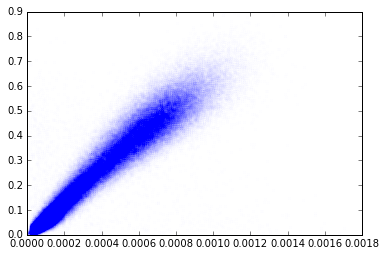

In [183]:
plot(x,y,'.',alpha=0.003)
show()

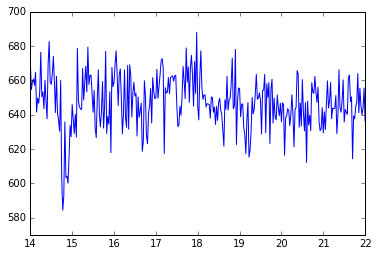

In [239]:
#removing the vectorized custom binned statistic and replacing with supported one
#first one below is the unweighted average
binned_acqiris = binned_statistic_dd(z,y,bins=[my_bins],statistic=average)
binned_GMD = binned_statistic_dd(z,x,bins=[my_bins],statistic=average)
#plot(my_bins[:-1],(binned_acqiris.statistic/binned_GMD.statistic)[::-1])

#the one below is the weighted average
binned_weighted_acqiris = binned_statistic_dd(z,y/sy,bins=[my_bins],statistic=average)
binned_weights = binned_statistic_dd(z,1.0/sy,bins=[my_bins],statistic=average)
binned_GMD = binned_statistic_dd(z,x,bins=[my_bins],statistic=average)
plot(my_bins[:-1],(binned_weighted_acqiris.statistic/binned_weights.statistic/binned_GMD.statistic)[::-1])

#the one below is the trunctated mean
binned_acqiris = binned_statistic_dd(z,y,bins=[my_bins],statistic=quartile_mean)
binned_GMD = binned_statistic_dd(z,x,bins=[my_bins],statistic=quartile_mean)
#plot(my_bins[:-1],(binned_acqiris.statistic/binned_GMD.statistic)[::-1])

#shot be shot
binned_weighted_acqiris_div_GMD = binned_statistic_dd(z,(y/x),bins=[my_bins],statistic=quartile_mean)
#plot(my_bins[:-1],(binned_weighted_acqiris_div_GMD.statistic)[::-1])

#ylim(96,118)
ylim(570,700)
xlim(14,22)
show()


In [185]:
#one of the problems with binning is that points falling at the edge of only contribue to the bin they fall into. 
#This section adds a weighting for the distance from the bin edge. if a point falls on the edge of the bin, 
#it contributes only marginally to that bin and majority to the other bin

def weighted_binned_statistic(x,y,weights,bins,statistic):
    binned_weighted_statistic = binned_statistic_dd(x,y*weights,bins=[my_bins],statistic=average)
    binned_weights = binned_statistic_dd(x,1.0*weights,bins=[my_bins],statistic=average)
    
    return  binned_weighted_statistic.statistic/binned_weights.statistic

def binned_statistic_edge_corrected(x,y,sy,bins,statistic):
    #calculate two binned statistics
    bin_size = mean(diff(my_bins))
    bin_axis_weighting1 = (x%bin_size)
    
    #binned_data1 = weighted_binned_statistic(x,y,1.0/sy,bins,statistic)
    #binned_data2 = weighted_binned_statistic(x,y,1.0/sy,bins,statistic)
    
    #binned_data1 = weighted_binned_statistic(x,y,bin_axis_weighting1,bins,statistic)
    #binned_data2 = weighted_binned_statistic(x,y,(bin_size-bin_axis_weighting1),bins,statistic)
    
    binned_data1 = weighted_binned_statistic(x,y,1.0/sy*bin_axis_weighting1,bins,statistic)
    binned_data2 = weighted_binned_statistic(x+1*bin_size,y,1.0/sy*(bin_size-bin_axis_weighting1),bins,statistic)
    #is the shift on x in the line immediately above correct?
  
    return (binned_data1+binned_data2)/2
    
    

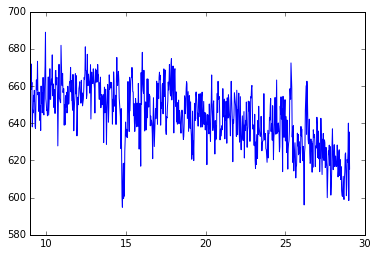

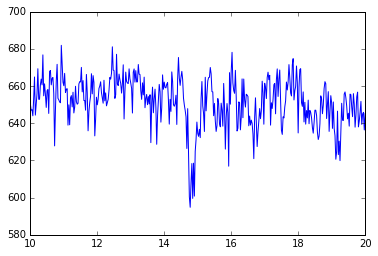

In [241]:
edge_corrected_data = binned_statistic_edge_corrected(z,y,sy,bins=[my_bins],statistic=average)/binned_statistic_edge_corrected(z,x,ones(len(x)),bins=[my_bins],statistic=average)
plot(my_bins[:-1],edge_corrected_data[::-1])
ylim(580,700)
xlim(9,30)
show()
plot(my_bins[:-1],edge_corrected_data[::-1])
ylim(580,700)
xlim(10,20)
show()

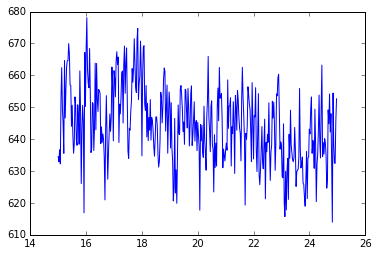

In [227]:
temp_mask = my_bins[:-1]>15
temp_mask *=  my_bins[:-1]<25
plot(my_bins[:-1][temp_mask],edge_corrected_data[::-1][temp_mask])
show()

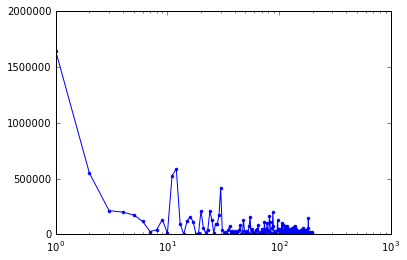

In [228]:
my_fft=(abs(fft(edge_corrected_data[::-1][temp_mask]))**2)[:int(sum(temp_mask/2))]
plot(my_fft,'.-')
semilogx()
ylim(1e2,2e6)
xlim()
show()

In [229]:
df = 1.0/(max(my_bins[:-1][temp_mask])-min(my_bins[:-1][temp_mask]))
peak_frequency = (argmax(my_fft[2:])+2)*df
print(peak_frequency)


1.2030075188


In [242]:
df*27

2.7067669172931939